In [89]:
# import libraries

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

%run ./scripts/util_func.py
%run ./scripts/model_func.py

In [120]:
# import arrays

icp_states = np.load('./data/icp_states_nojoy_doughnut1.npy', allow_pickle=True) # [time, icp_index, icp_x, icp_y, icp_yaw]
wheel_vels_cmd = np.load('./data/wheel_vels_nojoy_doughnut1.npy', allow_pickle=True) # [time, icp_index, vel_l, vel_r]
wheel_vels_meas = np.load('./data/wheel_vels_meas_nojoy_doughnut1.npy', allow_pickle=True) # [time, icp_index, vel_l, vel_r]
wheel_vels_pwrtrn = np.load('./data/wheel_vels_pwrtrn_nojoy_doughnut1.npy', allow_pickle=True) # [time, icp_index, vel_l, vel_r]

k_train = np.load('./data/icr_train_doughnut1.npy', allow_pickle=True) # [time, icp_index, vel_l, vel_r]

print(wheel_vels_meas)
print(wheel_vels_pwrtrn)

[[0.0 19.0 0.0 0.0]
 [0.051003648000000006 20.0 0.0 0.0]
 [0.097854464 20.0 0.0 0.0]
 ...
 [2157.70171264 21251.0 0.0 0.0]
 [2157.7469585920003 21252.0 0.0 0.0]
 [2157.7972864000003 21252.0 0.0 0.0]]
[[0.00000000e+00 1.90000000e+01 0.00000000e+00 0.00000000e+00]
 [5.10036480e-02 2.00000000e+01 0.00000000e+00 0.00000000e+00]
 [9.78544640e-02 2.00000000e+01 0.00000000e+00 0.00000000e+00]
 ...
 [2.15770171e+03 2.12510000e+04 1.30000000e+01 9.46697425e+00]
 [2.15774696e+03 2.12520000e+04 1.30000000e+01 9.46693002e+00]
 [2.15779729e+03 2.12520000e+04 1.30000000e+01 9.46689593e+00]]


In [167]:
# RUN IPEM with an EKF on entire trajectory

# params from crv
r = 0.3 # wheel radius : meters
alpha_l = 0.81 # left side friction loss
alpha_r = 0.84 # right side friction loss
alpha_max = 1.0 # bound alpha values
alpha_min = 0.0
x_icr = -2.71 # vehicle x_icr
y_icr_l = 3.0 # left wheels icr in y coordinates
y_icr_r = -3.85 # right wheels icr in y coordinates
k = np.array([alpha_l, alpha_r, x_icr, y_icr_l, y_icr_r])
k = np.array([1.0, 1.0,  1.0, 1.0, -1.0])
# k = k_train # init EKF params with trained params for traj.
J_icr = np.array([[-y_icr_r, y_icr_l], [x_icr, -x_icr], [-1, 1]])
J_alpha = np.array([[alpha_l, 0], [0, alpha_r]])

ekf_window = 0.5

err = 0
edd_pose = icp_states[0, 2:]
edd_pose_add = np.zeros((3,5))
edd_pose_add[0,:] = icp_states[0, 2]
edd_pose_add[1,:] = icp_states[0, 3]
edd_pose_add[2,:] = icp_states[0, 4]
vel_count = 0
icp_disp = 0
index_start = 0

# k_arr = np.zeros((1, k.shape[0] + 3))
k_arr = [k]
z_arr = []
icp_disp_arr = []

propa_cos = np.cos(icp_states[0,4])
propa_sin = np.sin(icp_states[0,4])
propa_mat = np.array([[propa_cos, -propa_sin, 0.0], 
                  [propa_sin, propa_cos, 0.0], [0.0, 0.0, 1.0]])

# EKF init
meas_jac = np.zeros((3, 5))
epsilon = 0.1
dk_arr = np.eye(5,5) * epsilon

P_init_alpha = 0.001**2
P_init_ICR = 0.001**2

Q_noise_alpha = 0.0001**2
Q_noise_ICR = 0.0001**2

R_xy_noise = 0.01**2
R_ang_noise = (np.pi / 180)**2

P = np.array([[P_init_alpha, 0.0, 0.0, 0.0, 0.0], [0.0, P_init_alpha, 0.0, 0.0, 0.0], [0.0, 0.0, P_init_ICR, 0.0, 0.0], 
              [0.0, 0.0, 0.0, P_init_ICR, 0.0], [0.0, 0.0, 0.0, 0.0, P_init_ICR]])
Q = np.array([[Q_noise_alpha, 0.0, 0.0, 0.0, 0.0], [0.0, Q_noise_alpha, 0.0, 0.0, 0.0], [0.0, 0.0, Q_noise_ICR, 0.0, 0.0], 
              [0.0, 0.0, 0.0, Q_noise_ICR, 0.0], [0.0, 0.0, 0.0, 0.0, Q_noise_ICR]])
R = np.array([[R_xy_noise, 0.0, 0.0], [0.0, R_xy_noise, 0.0], [0.0, 0.0, R_ang_noise]])

I_5 = np.eye(5,5)

icp_meas_arr = [icp_states[0, 2:]]
edd_pred_arr = [icp_states[0, 2:]]
    
for i in range(icp_states.shape[0] - 1):
    
    dt = icp_states[i+1, 0] - icp_states[i, 0]
    icp_disp = icp_disp + comp_disp(icp_states[i+1, 2:3], icp_states[i, 2:3])

    propa_mat = up_propa_mat(propa_mat, edd_pose[2])
    edd_pose = edd_pose + propa_mat @ icr_diff_drive(wheel_vels_pwrtrn[i, 2:], k, J_icr, J_alpha) * dt
    edd_pose[2] = wrap2pi(edd_pose[2])
    
    for j in range(edd_pose_add.shape[1]):
        propa_mat = up_propa_mat(propa_mat, edd_pose_add[2, j])
        edd_pose_add[:, j] = edd_pose_add[:,j] + propa_mat @ icr_diff_drive(wheel_vels_pwrtrn[i, 2:], 
                                                                            k + dk_arr[j,:], J_icr, J_alpha) * dt
        edd_pose_add[2, j] = wrap2pi(edd_pose_add[2, j])
    
    
    # filter icp jumps caused by controller input
    if icp_states[i+1, 0] - icp_states[i, 0] >= 0.5:
        icp_disp = 0.0
        edd_pose = icp_states[i, 2:]
        edd_pose_add[0,:] = icp_states[i, 2]
        edd_pose_add[1,:] = icp_states[i, 3]
        edd_pose_add[2,:] = icp_states[i, 4]

    # update IPEM EKF params when ICP window is reached
    if icp_disp >= ekf_window:
        icp_disp_arr.append(icp_disp)
        
        meas_jac[:, 0] = forward_diff(edd_pose_add[:,0], edd_pose, epsilon)
        meas_jac[:, 1] = forward_diff(edd_pose_add[:,1], edd_pose, epsilon)
        meas_jac[:, 2] = forward_diff(edd_pose_add[:,2], edd_pose, epsilon)
        meas_jac[:, 3] = forward_diff(edd_pose_add[:,3], edd_pose, epsilon)
        meas_jac[:, 4] = forward_diff(edd_pose_add[:,4], edd_pose, epsilon)
        
        P = P + Q
        
        z = icp_states[i, 2:] - edd_pose
        z[2] = wrap2pi(z[2]) # wrap angular error to [-pi, pi] 
        
        S = meas_jac @ P @ meas_jac.T + R
        
        K = P @ meas_jac.T @ np.linalg.inv(S)
        
        k = k + K @ z
        
#         k[:2] = np.clip(k[:1], alpha_min, alpha_max) # to bound alpha parameters between 0 and 1
        
        k_arr.append(k)
        
        P = (I_5 - K @ meas_jac) @ P

        icp_meas_arr.append(icp_states[i, 2:])
        edd_pred_arr.append(edd_pose)
        z_arr.append(z)
        
        icp_disp = 0.0
        edd_pose = icp_states[i, 2:]
        edd_pose_add[0,:] = icp_states[i, 2]
        edd_pose_add[1,:] = icp_states[i, 3]
        edd_pose_add[2,:] = icp_states[i, 4]
        
        

k_arr = np.asarray(k_arr)
z_arr = np.asarray(z_arr)
icp_disp_arr = np.asarray(icp_disp_arr)
icp_meas_arr = np.asarray(icp_meas_arr)
edd_pred_arr = np.asarray(edd_pred_arr)

np.save('data/EKF_params_doughnut1.npy', k)

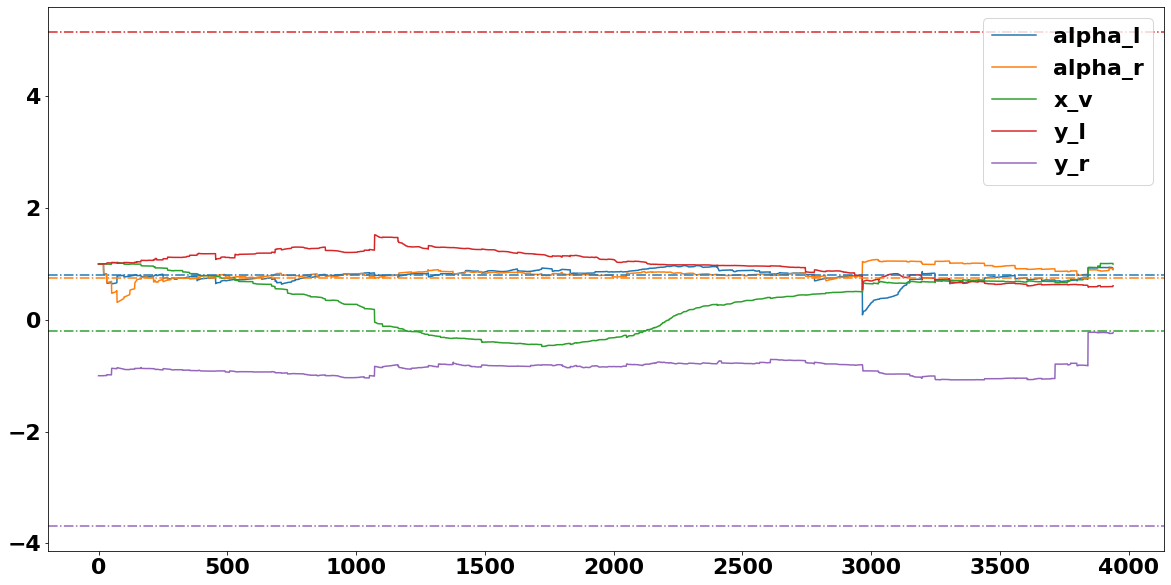

In [168]:
# plot parameters evolution
fig_1, axs1 = plt.subplots(1, 1, figsize = (20, 10))

# plot EKF params
axs1.plot(k_arr[:, 0], label = 'alpha_l')
axs1.plot(k_arr[:, 1], label = 'alpha_r')
axs1.plot(k_arr[:, 2], label = 'x_v')
axs1.plot(k_arr[:, 3], label = 'y_l')
axs1.plot(k_arr[:, 4], label = 'y_r')

# plot optimization result params
plt.axhline(y=k_train[0], color='tab:blue', linestyle='-.')
plt.axhline(y=k_train[1], color='tab:orange', linestyle='-.')
plt.axhline(y=k_train[2], color='tab:green', linestyle='-.')
plt.axhline(y=k_train[3], color='tab:red', linestyle='-.')
plt.axhline(y=k_train[4], color='tab:purple', linestyle='-.')
axs1.legend()

In [169]:
# take a look at final parameters values

print(k)

[0.9013314273874831 0.900619459088968 0.9981772531731594
 0.6097832050763476 -0.22841896374886755]


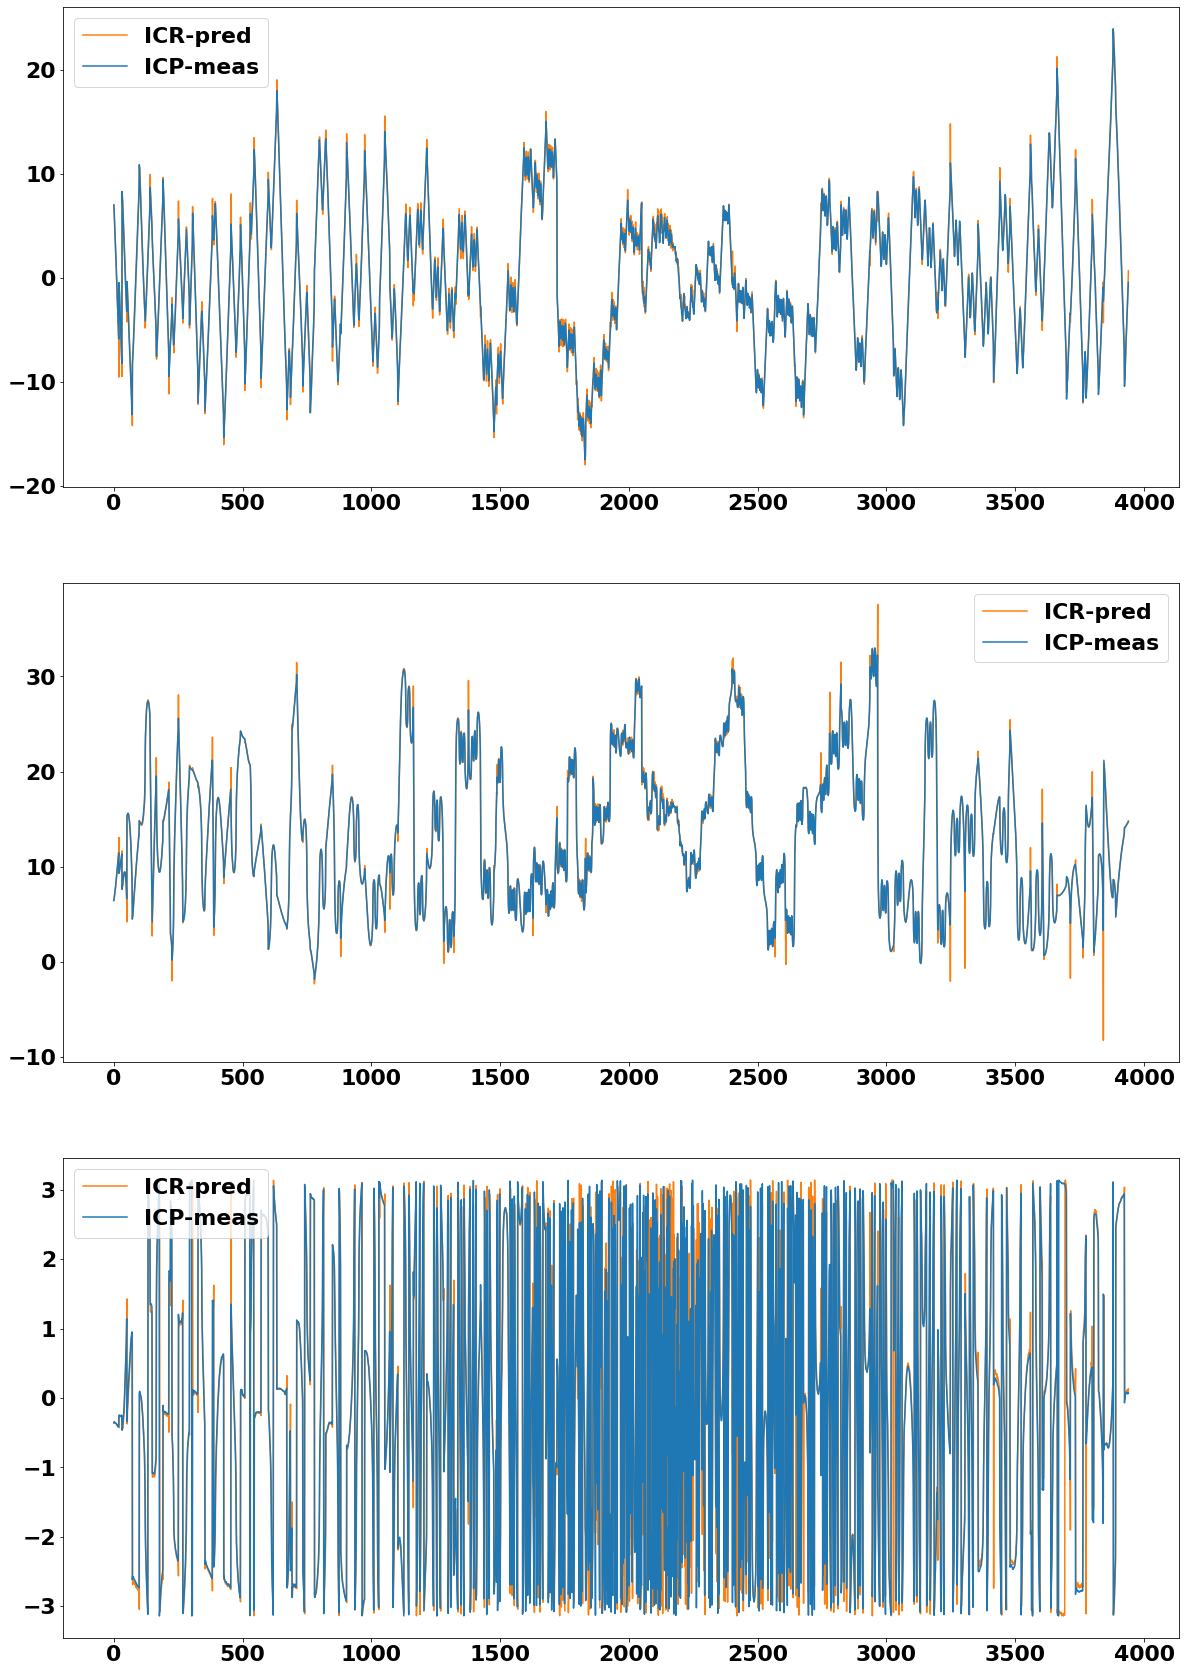

In [125]:
# plot predicted poses vs icp poses
fig_2, axs2 = plt.subplots(3, 1, figsize = (20, 30))
axs2[0].plot(edd_pred_arr[:,0], c = 'tab:orange', label='ICR-pred')
axs2[0].plot(icp_meas_arr[:,0], c = 'tab:blue', label='ICP-meas')
axs2[1].plot(edd_pred_arr[:,1], c = 'tab:orange', label='ICR-pred')
axs2[1].plot(icp_meas_arr[:,1], c = 'tab:blue', label='ICP-meas')
axs2[2].plot(edd_pred_arr[:,2], c = 'tab:orange', label='ICR-pred')
axs2[2].plot(icp_meas_arr[:,2], c = 'tab:blue', label='ICP-meas')

for ax in axs2:
    ax.legend()